In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
from scipy import stats

# Load data:

* to include `booking_origin` and `route` use `df_train.csv` and `df_val.csv`.
* to exclude `booking_origin` use `df_train_alt_wobo.csv` and `df_val_alt_wobo.csv`.
* to exclude `route` use `df_train_alt_wor.csv` and `df_val_alt_wor.csv`.

In [2]:
df_train = pd.read_csv('data/df_train_alt_wor.csv', index_col='index')
df_val = pd.read_csv('data/df_val_alt_wor.csv', index_col='index')

In [3]:
df_train.head(5)

,sales_channel_Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip,flight_day_Fri,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,...,booking_origin_binned_other,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
index,,,,,,,,,,,,,,,,,,,,,
17512,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1,2,30,8,1,1,1,4.75,1
48688,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1,347,6,15,1,0,0,4.67,1
12773,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1,36,30,14,1,1,1,7.57,0
23931,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2,70,25,1,1,0,1,5.62,0
15386,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1,8,61,4,1,0,1,4.75,0


In [4]:
# df_train = df_train.drop('index',axis=1)
# df_val = df_val.drop('index',axis=1)

## Upsampling

We split the data into 4 sets, then upsample each to have an equal number of bookings completed as not. This should reduce bias of the model towards predicting incomplete.

In [5]:
def upsample(df):
    # Take a random sample of incomplete bookings so that the training set has 50/50 complete/incomplete
    df_sub_0 = df[df['booking_complete']==0]
    df_sub_1 = df[df['booking_complete']==1].sample(df_sub_0.shape[0],replace=True)

    return pd.concat([df_sub_0,df_sub_1])

In [6]:
# to split the training set
strat_kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=1)
# to store the cv index sets
train_indices = []
# to temporarily store the pieces of the training set (upscaled)
split_dfs = []
# to help set the cv index sets
current_index = 0

for train_index, test_index in strat_kf.split(df_train.drop('booking_complete', axis=1), df_train['booking_complete']):
    # get training data upsamples for this split
    split_dfs.append(upsample(df_train.iloc[train_index]).reset_index(drop=True))
    # add the index values for these  (for after concat performed)
    train_indices.append([current_index + x for x in range(split_dfs[-1].shape[0])])
    # increase for next step
    current_index += split_dfs[-1].shape[0]

# concatenate the pieces to get one big set again
upscaled_df = pd.concat(split_dfs,ignore_index=True)
# get the cv split indices in the form (train, test)
cv_split = []
for i in range(4):
    train_index = train_indices[i]
    test_index = []
    for j in range(4):
        if i != j:
            test_index += train_indices[j]
    cv_split.append((train_index , test_index))

# quick reshaping of the data, and separate features and target
y_train = upscaled_df['booking_complete'].to_numpy().reshape((-1,))
y_val = df_val['booking_complete'].to_numpy().reshape((-1,))

X_train = upscaled_df.drop('booking_complete', axis=1).to_numpy()
X_val = df_val.drop('booking_complete', axis=1).to_numpy()

# Baseline random forest model

In [8]:
rfc = RandomForestClassifier(
    n_estimators=1000,
    max_depth=10
)

In [9]:
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000)

In [10]:
def print_scores(model):
    print('-'*20,'\nTraining score:\n'+'-'*20)
    print(model.score(X_train,y_train))
    y_preds = model.predict_proba(X_train)[:,1]
    print(f'ROC AUC: {roc_auc_score(y_train, y_preds):.3f}')
    print('-'*20,'\nVal score:\n'+'-'*20)
    print(model.score(X_val,y_val))
    y_preds = model.predict_proba(X_val)[:,1]
    print(f'ROC AUC: {roc_auc_score(y_val, y_preds):.3f}')

print_scores(rfc)

-------------------- 
Training score:
--------------------
0.7431974566675377
ROC AUC: 0.816
-------------------- 
Val score:
--------------------
0.6786
ROC AUC: 0.749


# Grid search for random forest

We perform a random grid search on four hyperparameters, running for 100 candidates.

In [11]:
param_grid = {
    'n_estimators' : stats.geom(0.01),
    'max_depth' : stats.randint(2,100),
    'min_samples_split' : stats.randint(2,40),
    'max_samples' : stats.beta(a=8, b=3)
}

rfc_grid = RandomizedSearchCV(
    rfc, 
    param_distributions=param_grid,
    cv=cv_split,
    scoring='roc_auc',
    n_iter=100,
    verbose=1
)

In [12]:
rfc_grid.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [57406, 57407, 57408, 57409, 57410, 57411, 57412, 57413,
                         57414, 57415, 57416, 57417, 57418, 57419, 57420, 57421,
                         57422, 57423, 57424, 57425, 57426, 57427, 57428, 57429,
                         57430, 57431, 57432, 57433, 57434, 57435, ...]),
                       ([57406, 57407, 57408, 57409, 57410, 57411, 57412, 57413,
                         574...
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000286541309A0>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028654130D60>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002865362C1F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002865362C6D0>},
                   scoring='roc_auc', verbose=1)

In [13]:
cv_results = pd.DataFrame(rfc_grid.cv_results_).sort_values('rank_test_score')
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_samples,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
6,21.573697,0.287430,16.046002,0.253492,69,0.886317,4,423,"{'max_depth': 69, 'max_samples': 0.88631666815...",0.950403,0.949380,0.950632,0.948442,0.949714,0.000873,1
8,5.633136,0.162181,3.932766,0.087050,58,0.948318,4,99,"{'max_depth': 58, 'max_samples': 0.94831789610...",0.949999,0.948736,0.950776,0.948125,0.949409,0.001039,2
59,3.179282,0.031418,2.218508,0.013396,81,0.847439,3,63,"{'max_depth': 81, 'max_samples': 0.84743861394...",0.949418,0.948278,0.948994,0.947347,0.948509,0.000785,3
21,3.261239,0.250814,2.191947,0.101580,74,0.823067,4,53,"{'max_depth': 74, 'max_samples': 0.82306723408...",0.945809,0.944560,0.946308,0.944610,0.945322,0.000758,4
54,14.393290,0.598416,11.055822,0.031235,36,0.756197,5,322,"{'max_depth': 36, 'max_samples': 0.75619669880...",0.945411,0.943727,0.945828,0.943176,0.944536,0.001111,5


In [14]:
rf_best_model = rfc_grid.best_estimator_

print_scores(rf_best_model)

-------------------- 
Training score:
--------------------
0.9998824144238306
ROC AUC: 1.000
-------------------- 
Val score:
--------------------
0.8452
ROC AUC: 0.733


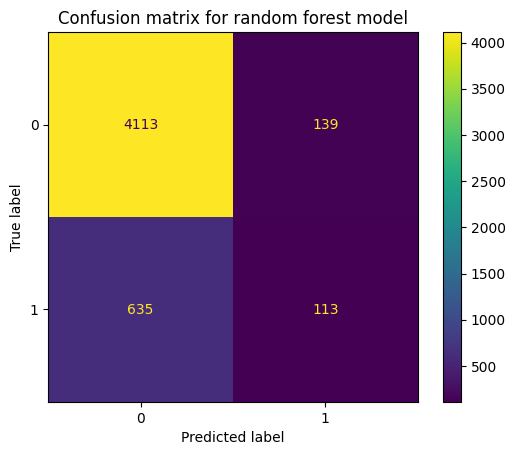

In [33]:
ConfusionMatrixDisplay.from_estimator(rf_best_model, X_val, y_val)
plt.title('Confusion matrix for random forest model')
plt.show()

# Gradient boosting

We again run a random grid search over 100 combinations, this time of five hyperparameters.

In [16]:
gbc = HistGradientBoostingClassifier()

param_grid = {
    'max_iter' : stats.geom(0.004),
    'max_depth' : stats.randint(2,100),
    'max_leaf_nodes' : stats.randint(20,60),
    'l2_regularization' : stats.beta(a=1, b=6),
    'learning_rate' : stats.beta(a=1.003, b=20)
}

gbc_grid = RandomizedSearchCV(
    gbc, 
    param_distributions=param_grid,
    cv=cv_split,
    scoring='roc_auc',
    n_iter=100,
    verbose=1
)

In [17]:
gbc_grid.fit(X_train,y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [57406, 57407, 57408, 57409, 57410, 57411, 57412, 57413,
                         57414, 57415, 57416, 57417, 57418, 57419, 57420, 57421,
                         57422, 57423, 57424, 57425, 57426, 57427, 57428, 57429,
                         57430, 57431, 57432, 57433, 57434, 57435, ...]),
                       ([57406, 57407, 57408, 57409, 57410, 57411, 57412, 57413,
                         574...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000286541A26A0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002860FD923A0>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028615F0FD00>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028655A57A00>},
                   scoring='roc_auc', verbose=1)

In [18]:
cv_results = pd.DataFrame(gbc_grid.cv_results_).sort_values('rank_test_score')
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_regularization,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
66,22.268243,0.594768,4.750843,0.062975,0.04139,0.34543,17,792,44,"{'l2_regularization': 0.04138995043108989, 'le...",0.924458,0.919073,0.923212,0.918772,0.921379,0.002498,1
43,13.108289,0.206196,2.058055,0.043903,0.027025,0.303662,54,519,52,"{'l2_regularization': 0.027024637579509368, 'l...",0.922613,0.914812,0.917387,0.916032,0.917711,0.002973,2
22,17.930639,0.785533,5.327561,0.623671,0.250956,0.11642,85,797,27,"{'l2_regularization': 0.25095555455865987, 'le...",0.897260,0.888062,0.891569,0.888987,0.891470,0.003581,3
27,23.304608,0.979629,4.474288,0.701120,0.081422,0.050448,29,773,54,"{'l2_regularization': 0.08142162208621481, 'le...",0.894930,0.888973,0.893832,0.886579,0.891078,0.003431,4
50,17.271332,2.192874,3.621794,0.858325,0.062225,0.083632,73,433,56,"{'l2_regularization': 0.06222458257985881, 'le...",0.894826,0.891241,0.892667,0.885433,0.891042,0.003480,5


In [19]:
gb_best_model = gbc_grid.best_estimator_
print_scores(gb_best_model)

-------------------- 
Training score:
--------------------
0.9938855500391952
ROC AUC: 1.000
-------------------- 
Val score:
--------------------
0.7988
ROC AUC: 0.703


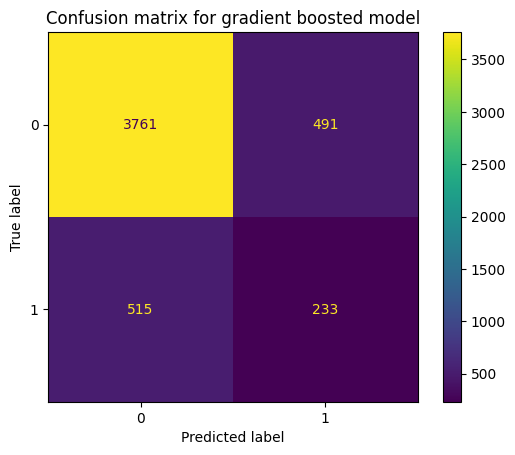

In [32]:
ConfusionMatrixDisplay.from_estimator(gb_best_model, X_val, y_val)
plt.title('Confusion matrix for gradient boosted model')
plt.show()

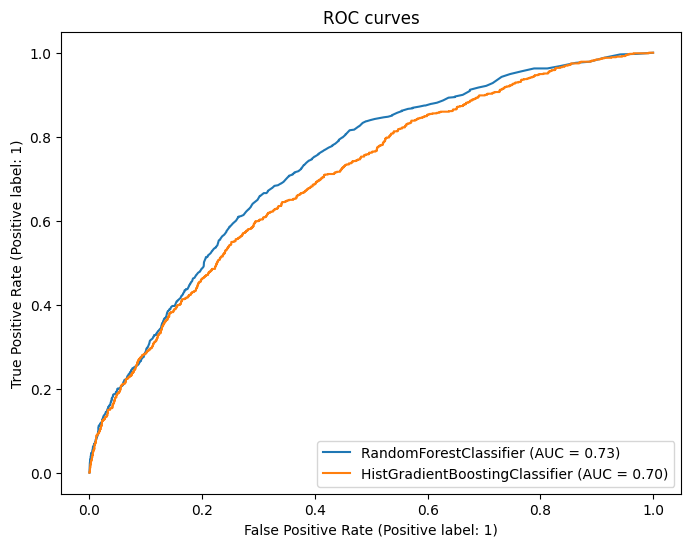

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
RocCurveDisplay.from_estimator(rf_best_model, X_val, y_val, ax=ax)
RocCurveDisplay.from_estimator(gb_best_model, X_val, y_val, ax=ax)
plt.title('ROC curves')
plt.show()

# Conclusion

The random forest classifier performed better in every metric except recall. Both models though have low recall.

# Feature importances

We identify the top 20 features by their frequency of usage in the random forest model.

In [23]:
FI = pd.DataFrame(rf_best_model.feature_importances_, index=df_train.drop('booking_complete',axis=1).columns)
FI.sort_values(0, ascending=False).head(20)

,0
purchase_lead,0.208505
flight_hour,0.155891
length_of_stay,0.149594
flight_duration,0.090886
booking_origin_binned_Australia,0.064587
num_passengers,0.051742
booking_origin_binned_Malaysia,0.039614
wants_in_flight_meals,0.021528
wants_extra_baggage,0.017630
wants_preferred_seat,0.017446


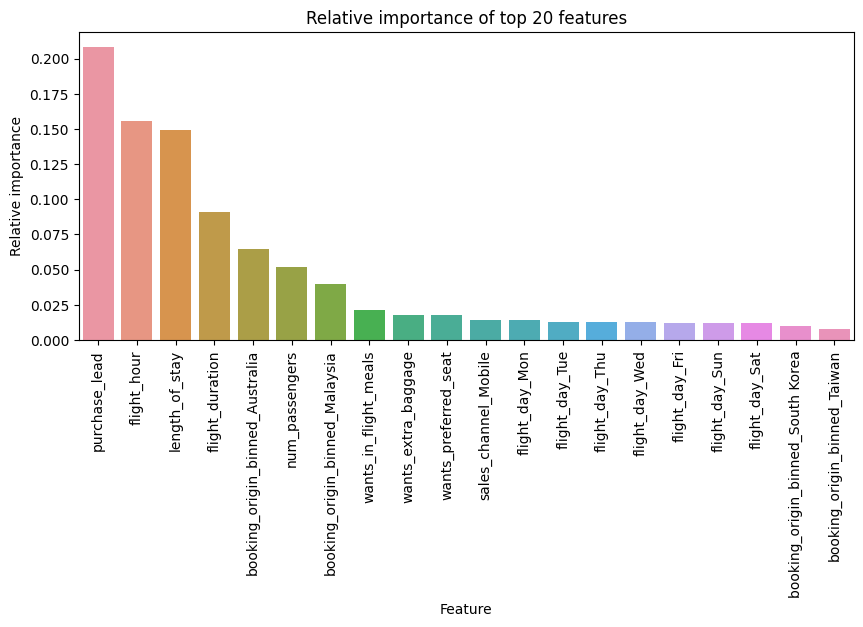

In [31]:
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(
    FI.sort_values(0, ascending=False).head(20).reset_index(),
    x='index',
    y=0,
    ax=ax
)
ax.set_xlabel('Feature')
ax.set_ylabel('Relative importance')
ax.set_title('Relative importance of top 20 features')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()